In [57]:
# Import libraries
'''
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
'''

# Pretty display for notebooks
'''
%matplotlib inline
'''

# Allows the use of display() for DataFrames
from IPython.display import display 

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
weather = pd.read_csv("../asset/weather.csv")
key = pd.read_csv("../asset/key.csv")
submission_example = pd.read_csv("../asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission_example.shape)

import pickle
import costum_functions as cf

slack_url = pickle.load(open('slackUrl.pickle', 'rb'))
slack_url

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_weather = weather.copy()
df_key = key.copy()
df_test = test.copy()

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


In [3]:
import datetime

def addDays(date):
    temp = date.split("-")
    year, month, date = int(temp[0]), int(temp[1]), int(temp[2])
    return datetime.datetime(year, month, date).weekday()

In [ ]:
# df_train_with_weather["day"] = df_train_with_weather["date"].apply(addDays)

In [4]:
df_train.tail()

date  store_nbr  item_nbr  units
4617595  2014-10-31         45       107      0
4617596  2014-10-31         45       108      0
4617597  2014-10-31         45       109      0
4617598  2014-10-31         45       110      0
4617599  2014-10-31         45       111      0

In [5]:
df_key.tail()

store_nbr  station_nbr
40         41           12
41         42           14
42         43           11
43         44           12
44         45           16

In [6]:
df_weather.tail()

station_nbr        date tmax tmin tavg depart dewpoint wetbulb heat  \
20512           16  2014-10-31   53   34   44      M       35      41   21   
20513           17  2014-10-31   59   34   47      M       32      41   18   
20514           18  2014-10-31   67   49   58     -4       40      50    7   
20515           19  2014-10-31   45   33   39     -6       24      32   26   
20516           20  2014-10-31   68   50   59      M       39      50    6   

      cool sunrise sunset codesum snowfall preciptotal stnpressure sealevel  \
20512    0       -      -                M        0.00       29.90    29.99   
20513    0       -      -      RA      0.0        0.00       29.72    30.39   
20514    0    0644   1738              0.0        0.00       29.78    30.28   
20515    0    0624   1646   RA SN      0.1        0.02       29.51    30.24   
20516    0       -      -              0.0        0.00       29.57    30.27   

      resultspeed resultdir avgspeed  
20512         4.5        03      5.3  
20513         9.2        01      9.3  
20514        10.6        36     11.2  
20515        20.4        34     20.9  
20516        10.5        36     11.2

In [7]:
df_test.tail()

date  store_nbr  item_nbr
526912  2014-10-26         45       107
526913  2014-10-26         45       108
526914  2014-10-26         45       109
526915  2014-10-26         45       110
526916  2014-10-26         45       111

In [9]:
df_train_key = df_train.merge(df_key, on=["store_nbr"], how="inner")
df_train_key.tail()

date  store_nbr  item_nbr  units  station_nbr
4617595  2014-10-31         35       107      0            5
4617596  2014-10-31         35       108      0            5
4617597  2014-10-31         35       109      0            5
4617598  2014-10-31         35       110      0            5
4617599  2014-10-31         35       111      0            5

In [10]:
total = df_train_key.merge(df_weather, on=["date","station_nbr"], how="inner")
total.tail()

date  store_nbr  item_nbr  units  station_nbr tmax tmin tavg  \
4617595  2014-10-31         35       107      0            5    M    M    M   
4617596  2014-10-31         35       108      0            5    M    M    M   
4617597  2014-10-31         35       109      0            5    M    M    M   
4617598  2014-10-31         35       110      0            5    M    M    M   
4617599  2014-10-31         35       111      0            5    M    M    M   

        depart dewpoint   ...    sunrise sunset codesum snowfall preciptotal  \
4617595      M       37   ...       0616   1640                M           M   
4617596      M       37   ...       0616   1640                M           M   
4617597      M       37   ...       0616   1640                M           M   
4617598      M       37   ...       0616   1640                M           M   
4617599      M       37   ...       0616   1640                M           M   

        stnpressure sealevel resultspeed resultdir avgspeed  
4617595           M    30.01        10.8        05        M  
4617596           M    30.01        10.8        05        M  
4617597           M    30.01        10.8        05        M  
4617598           M    30.01        10.8        05        M  
4617599           M    30.01        10.8        05        M  

[5 rows x 23 columns]

In [28]:
def column_type(df):
    columns_ls = list(df.columns)
    for column in columns_ls:
        print("{} : {}".format(str(column),str(total[column].dtype)))
        
column_type(total)

date : object
store_nbr : int64
item_nbr : int64
units : int64
station_nbr : int64
tmax : object
tmin : object
tavg : object
depart : object
dewpoint : object
wetbulb : object
heat : object
cool : object
sunrise : object
sunset : object
codesum : object
snowfall : object
preciptotal : object
stnpressure : object
sealevel : object
resultspeed : object
resultdir : object
avgspeed : object


In [16]:
total_nonzero = total[total["units"]!=0]
total_nonzero.tail()

date  store_nbr  item_nbr  units  station_nbr tmax tmin tavg  \
4617332  2014-10-29         35        66     14            5    M    M    M   
4617393  2014-10-30         35        16     16            5    M    M    M   
4617443  2014-10-30         35        66      6            5    M    M    M   
4617504  2014-10-31         35        16     18            5    M    M    M   
4617554  2014-10-31         35        66     10            5    M    M    M   

        depart dewpoint   ...    sunrise sunset codesum snowfall preciptotal  \
4617332      M       55   ...       0613   1643                M           M   
4617393      M       38   ...       0615   1641                M           M   
4617443      M       38   ...       0615   1641                M           M   
4617504      M       37   ...       0616   1640                M           M   
4617554      M       37   ...       0616   1640                M           M   

        stnpressure sealevel resultspeed resultdir avgspeed  
4617332           M    29.87         8.2        23        M  
4617393           M    29.95         8.3        30        M  
4617443           M    29.95         8.3        30        M  
4617504           M    30.01        10.8        05        M  
4617554           M    30.01        10.8        05        M  

[5 rows x 23 columns]

In [19]:
len(total_nonzero)

118696

In [ ]:
# station별로 missing data 일단 삭제해서 pairplot으로 상관관계를 보자(station 6~10)

In [97]:
# M value row 모두 삭제
# T value 모두 0으로 변환
df_station_6 = df_weather[df_weather["station_nbr"]==6].reset_index(drop=True)
df_station_7 = df_weather[df_weather["station_nbr"]==7].reset_index(drop=True)
df_station_8 = df_weather[df_weather["station_nbr"]==8].reset_index(drop=True)
df_station_9 = df_weather[df_weather["station_nbr"]==9].reset_index(drop=True)
df_station_10 = df_weather[df_weather["station_nbr"]==10].reset_index(drop=True)

In [98]:
len(df_station_6),len(df_station_7), len(df_station_8), len(df_station_9), len(df_station_10)

(1035, 1035, 1035, 1035, 1035)

In [208]:
def isThereNoneData(df, percentage=60):
    """
        Missing data, Trace data의 개수정보를 받아서 만든 dataframe을 리턴한다.
        패러미터는 df만 받는다.(weather df에서만 M, T가 존재하므로 그 외에는 의미가 없다.)
    """
    columns = ["Column", "Row Count", "Missing Data", "M Data %", "Trace Data", "T Data %", "Bar Data", "B Data %"]
    li = list(df.columns)
    m_count_li = []
    t_count_li = []
    b_count_li = []    
    row_count_li = []
    m_percent_li = []
    t_percent_li = []
    b_percent_li = []
    for l in li:
        m_count = 0
        t_count = 0
        b_count = 0
        for i, contents in enumerate(df[l]):
            contents = str(contents)
            if(contents.strip() == "M"):
                m_count += 1
            if(contents.strip() == "T"):
                t_count += 1
            if(contents.strip() == "-"):
                b_count += 1            
        m_count_li.append(m_count)
        t_count_li.append(t_count)
        b_count_li.append(b_count)
        row_count_li.append(len(df[l]))
        m_percent_li.append(round(m_count/len(df[l])*100,2))
        t_percent_li.append(round(t_count/len(df[l])*100,2))
        b_percent_li.append(round(b_count/len(df[l])*100,2))
#         m_percent_li.append("{}%".format(round(m_count/len(df[l])*100,2)))
#         t_percent_li.append("{}%".format(round(t_count/len(df[l])*100,2)))
#         b_percent_li.append("{}%".format(round(b_count/len(df[l])*100,2)))
    result_df = pd.DataFrame({"Column" : li, "Row Count" : row_count_li,
                         "Missing Data" : m_count_li, "M Data %" : m_percent_li,
                         "Trace Data" : t_count_li, "T Data %": t_percent_li,
                         "Bar Data" : b_count_li, "B Data %" : b_percent_li}, columns=columns) 

    print("M Data over {}% : {}".format(percentage, list(result_df["Column"][result_df["M Data %"] >= percentage])))
    print("T Data over {}% : {}".format(percentage, list(result_df["Column"][result_df["T Data %"] >= percentage])))
    print("B Data over {}% : {}".format(percentage, list(result_df["Column"][result_df["B Data %"] >= percentage])))
#     print(result_df[result_df.loc["M Data %"]=="100.0%"].columns)
    return result_df

In [184]:
isThereNoneData_1(df_station_6)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


Column  Row Count  Missing Data  M Data %  Trace Data  T Data %  \
0   station_nbr       1035             0      0.00           0      0.00   
1          date       1035             0      0.00           0      0.00   
2          tmax       1035             2      0.19           0      0.00   
3          tmin       1035             2      0.19           0      0.00   
4          tavg       1035             6      0.58           0      0.00   
5        depart       1035            37      3.57           0      0.00   
6      dewpoint       1035             0      0.00           0      0.00   
7       wetbulb       1035             3      0.29           0      0.00   
8          heat       1035             6      0.58           0      0.00   
9          cool       1035             6      0.58           0      0.00   
10      sunrise       1035             0      0.00           0      0.00   
11       sunset       1035             0      0.00           0      0.00   
12      codesum       1035             0      0.00           0      0.00   
13     snowfall       1035             9      0.87          14      1.35   
14  preciptotal       1035             2      0.19         157     15.17   
15  stnpressure       1035             4      0.39           0      0.00   
16     sealevel       1035             3      0.29           0      0.00   
17  resultspeed       1035             0      0.00           0      0.00   
18    resultdir       1035             0      0.00           0      0.00   
19     avgspeed       1035             2      0.19           0      0.00   

    Bar Data  B Data %  
0          0       0.0  
1          0       0.0  
2          0       0.0  
3          0       0.0  
4          0       0.0  
5          0       0.0  
6          0       0.0  
7          0       0.0  
8          0       0.0  
9          0       0.0  
10        31       3.0  
11        31       3.0  
12         0       0.0  
13         0       0.0  
14         0       0.0  
15         0       0.0  
16         0       0.0  
17         0       0.0  
18         0       0.0  
19         0       0.0

In [185]:
isThereNoneData_1(df_station_7)

M Data over 60% : ['depart']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


Column  Row Count  Missing Data  M Data %  Trace Data  T Data %  \
0   station_nbr       1035             0      0.00           0      0.00   
1          date       1035             0      0.00           0      0.00   
2          tmax       1035            35      3.38           0      0.00   
3          tmin       1035            34      3.29           0      0.00   
4          tavg       1035            41      3.96           0      0.00   
5        depart       1035          1035    100.00           0      0.00   
6      dewpoint       1035            37      3.57           0      0.00   
7       wetbulb       1035            42      4.06           0      0.00   
8          heat       1035            41      3.96           0      0.00   
9          cool       1035            41      3.96           0      0.00   
10      sunrise       1035             0      0.00           0      0.00   
11       sunset       1035             0      0.00           0      0.00   
12      codesum       1035             0      0.00           0      0.00   
13     snowfall       1035            57      5.51          16      1.55   
14  preciptotal       1035             1      0.10         116     11.21   
15  stnpressure       1035             1      0.10           0      0.00   
16     sealevel       1035            39      3.77           0      0.00   
17  resultspeed       1035             3      0.29           0      0.00   
18    resultdir       1035             3      0.29           0      0.00   
19     avgspeed       1035             3      0.29           0      0.00   

    Bar Data  B Data %  
0          0       0.0  
1          0       0.0  
2          0       0.0  
3          0       0.0  
4          0       0.0  
5          0       0.0  
6          0       0.0  
7          0       0.0  
8          0       0.0  
9          0       0.0  
10      1035     100.0  
11      1035     100.0  
12         0       0.0  
13         0       0.0  
14         0       0.0  
15         0       0.0  
16         0       0.0  
17         0       0.0  
18         0       0.0  
19         0       0.0

In [186]:
df_station_8_1 = isThereNoneData_1(df_station_8)
df_station_8_1

M Data over 60% : ['depart', 'snowfall', 'sealevel']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


Column  Row Count  Missing Data  M Data %  Trace Data  T Data %  \
0   station_nbr       1035             0      0.00           0      0.00   
1          date       1035             0      0.00           0      0.00   
2          tmax       1035            14      1.35           0      0.00   
3          tmin       1035            12      1.16           0      0.00   
4          tavg       1035           468     45.22           0      0.00   
5        depart       1035          1035    100.00           0      0.00   
6      dewpoint       1035            50      4.83           0      0.00   
7       wetbulb       1035            64      6.18           0      0.00   
8          heat       1035           468     45.22           0      0.00   
9          cool       1035           468     45.22           0      0.00   
10      sunrise       1035             0      0.00           0      0.00   
11       sunset       1035             0      0.00           0      0.00   
12      codesum       1035             0      0.00           0      0.00   
13     snowfall       1035          1030     99.52           0      0.00   
14  preciptotal       1035             5      0.48          10      0.97   
15  stnpressure       1035            10      0.97           0      0.00   
16     sealevel       1035          1035    100.00           0      0.00   
17  resultspeed       1035            32      3.09           0      0.00   
18    resultdir       1035            32      3.09           0      0.00   
19     avgspeed       1035             5      0.48           0      0.00   

    Bar Data  B Data %  
0          0       0.0  
1          0       0.0  
2          0       0.0  
3          0       0.0  
4          0       0.0  
5          0       0.0  
6          0       0.0  
7          0       0.0  
8          0       0.0  
9          0       0.0  
10      1035     100.0  
11      1035     100.0  
12         0       0.0  
13         0       0.0  
14         0       0.0  
15         0       0.0  
16         0       0.0  
17         0       0.0  
18         0       0.0  
19         0       0.0

In [166]:
print("M data % over 60% : {}".format(list(df_station_8_1["Column"][df_station_8_1["M Data %"] >= 60])))
print("T data % over 60% : {}".format(list(df_station_8_1["Column"][df_station_8_1["T Data %"] >= 60])))
print("B data % over 60% : {}".format(list(df_station_8_1["Column"][df_station_8_1["B Data %"] >= 60])))
# df_station_8_1["Column"][df_station_8_1["T Data %"] >= 60]

M data % over 60% : ['depart', 'snowfall', 'sealevel']
T data % over 60% : []
B data % over 60% : ['sunrise', 'sunset']


In [187]:
isThereNoneData_1(df_station_9)

M Data over 60% : ['depart', 'snowfall']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


Column  Row Count  Missing Data  M Data %  Trace Data  T Data %  \
0   station_nbr       1035             0      0.00           0      0.00   
1          date       1035             0      0.00           0      0.00   
2          tmax       1035             6      0.58           0      0.00   
3          tmin       1035             7      0.68           0      0.00   
4          tavg       1035            19      1.84           0      0.00   
5        depart       1035          1035    100.00           0      0.00   
6      dewpoint       1035            16      1.55           0      0.00   
7       wetbulb       1035            64      6.18           0      0.00   
8          heat       1035            19      1.84           0      0.00   
9          cool       1035            19      1.84           0      0.00   
10      sunrise       1035             0      0.00           0      0.00   
11       sunset       1035             0      0.00           0      0.00   
12      codesum       1035             0      0.00           0      0.00   
13     snowfall       1035          1017     98.26           0      0.00   
14  preciptotal       1035             5      0.48         191     18.45   
15  stnpressure       1035             6      0.58           0      0.00   
16     sealevel       1035            14      1.35           0      0.00   
17  resultspeed       1035             3      0.29           0      0.00   
18    resultdir       1035             3      0.29           0      0.00   
19     avgspeed       1035             5      0.48           0      0.00   

    Bar Data  B Data %  
0          0       0.0  
1          0       0.0  
2          0       0.0  
3          0       0.0  
4          0       0.0  
5          0       0.0  
6          0       0.0  
7          0       0.0  
8          0       0.0  
9          0       0.0  
10      1035     100.0  
11      1035     100.0  
12         0       0.0  
13         0       0.0  
14         0       0.0  
15         0       0.0  
16         0       0.0  
17         0       0.0  
18         0       0.0  
19         0       0.0

In [188]:
isThereNoneData_1(df_station_10)

M Data over 60% : ['depart', 'snowfall']
T Data over 60% : []
B Data over 60% : []


Column  Row Count  Missing Data  M Data %  Trace Data  T Data %  \
0   station_nbr       1035             0      0.00           0      0.00   
1          date       1035             0      0.00           0      0.00   
2          tmax       1035             0      0.00           0      0.00   
3          tmin       1035             0      0.00           0      0.00   
4          tavg       1035             8      0.77           0      0.00   
5        depart       1035          1035    100.00           0      0.00   
6      dewpoint       1035             0      0.00           0      0.00   
7       wetbulb       1035             3      0.29           0      0.00   
8          heat       1035             8      0.77           0      0.00   
9          cool       1035             8      0.77           0      0.00   
10      sunrise       1035             0      0.00           0      0.00   
11       sunset       1035             0      0.00           0      0.00   
12      codesum       1035             0      0.00           0      0.00   
13     snowfall       1035          1035    100.00           0      0.00   
14  preciptotal       1035             1      0.10         157     15.17   
15  stnpressure       1035             1      0.10           0      0.00   
16     sealevel       1035             2      0.19           0      0.00   
17  resultspeed       1035             0      0.00           0      0.00   
18    resultdir       1035             0      0.00           0      0.00   
19     avgspeed       1035             1      0.10           0      0.00   

    Bar Data  B Data %  
0          0       0.0  
1          0       0.0  
2          0       0.0  
3          0       0.0  
4          0       0.0  
5          0       0.0  
6          0       0.0  
7          0       0.0  
8          0       0.0  
9          0       0.0  
10        31       3.0  
11        31       3.0  
12         0       0.0  
13         0       0.0  
14         0       0.0  
15         0       0.0  
16         0       0.0  
17         0       0.0  
18         0       0.0  
19         0       0.0

In [189]:
def changeTypeToInt(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    else:
        return int(a)
    
def changeTypeToFloat(a):
    temp = str(a).strip()
    if temp == 'M':
        return np.nan
    elif temp == 'T' or temp == '-':
        return 0
    else:
        return float(a)
    
def remove_m_row(df, columns = []):
    """
        m_row를 제거할 data_frame 파일을 df 패러미터로 넣어준다.
        columns를 패러미터로 안넣어줄 경우에는 전체 컬럼의 m값을 날린다.
        columns를 넣어주는 경우에는 반드시 리스트로 넣어줄것!! 예:) ["tmax", "tmin"]
        그리고 처리된 df를 리턴하는 것이므로!! 원하는 변수명으로 받아줄 것
        예:) df_test = remove_m_row(df_weather, ["tmax", "tmin"])
    """
    result_df = df.copy()
    if len(columns) == 0:
        columns = result_df.columns
    cols_int = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool", "sunrise", "sunset"]
    cols_float = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart", "resultspeed", "resultdir", "avgspeed"]
    for column in columns:
#         print(column)
        if column in cols_int:
            result_df[column] = result_df[column].apply(changeTypeToInt)
        elif column in cols_float:
            result_df[column] = result_df[column].apply(changeTypeToFloat)
    return result_df.dropna()

# weather = pd.read_csv("../asset/weather.csv") 테스트 용으로 추가해놓은 line입니다.

In [190]:
# 아래 예는 1번 스테이션을 이용했음.

station_1 = df_weather[df_weather["station_nbr"] == 1].reset_index(drop=True) 
station_1.drop("snowfall", axis=1, inplace=True) # 1번 경우에는 snowfall 컬럼 전체가 m 이므로 drop
station_1.drop("depart", axis=1, inplace=True) # 위와 동일
station_1_only_dropped_t = station_1.copy() # copy안하면 station_1이 변할 수 있으니 보호한다.
station_1_only_dropped_t = remove_m_row(station_1_only_dropped_t, ["tmax", "tmin", "tavg"])
station_1_dropped_all = remove_m_row(station_1)
print("원래 station_1의 row 개수" + str(len(station_1)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_1_only_dropped_t)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_1_dropped_all)))

원래 station_1의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1029
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수0


In [116]:
df_station_6_dropped_all = remove_m_row(df_station_6)
print("원래 station_6의 row 개수" + str(len(df_station_6)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_6_dropped_all)))

원래 station_6의 row 개수1035
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수986


In [205]:
col_t = ["tmax", "tmin", "tavg"]
col_d = ["dewpoint", "wetbulb"]
col_h = ["heat", "cool"] # , "sunrise", "sunset"
col_s = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
col_w = ["resultspeed", "avgspeed"] #, "resultdir"

In [191]:
df_station_6_only_dropped_t = df_station_6.copy()
df_station_6_only_dropped_t = remove_m_row(df_station_6, col_t)
print("원래 station_6의 row 개수" + str(len(df_station_6)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_6_only_dropped_t)))

원래 station_6의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1029


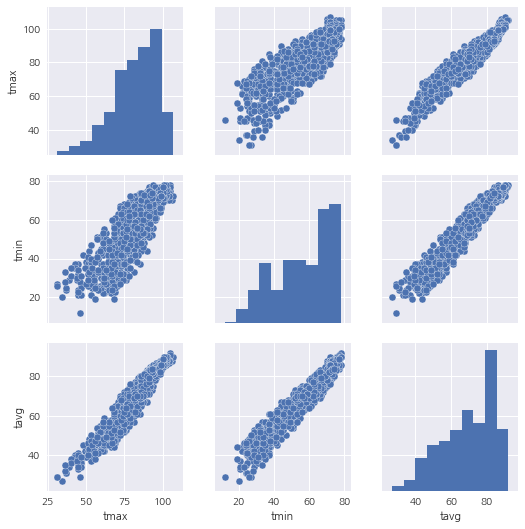

In [192]:
sns.pairplot(df_station_6_only_dropped_t[col_t])
plt.show()

In [193]:
df_station_6_only_dropped_d = df_station_6.copy()
df_station_6_only_dropped_d = remove_m_row(df_station_6, col_d)
print("원래 station_6의 row 개수" + str(len(df_station_6)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_6_only_dropped_d)))

원래 station_6의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1032


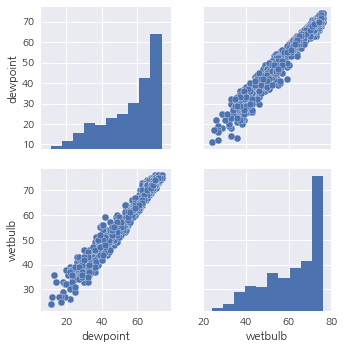

In [194]:
sns.pairplot(df_station_6_only_dropped_d[col_d])
plt.show()

In [206]:
df_station_6_only_dropped_h = df_station_6.copy()
df_station_6_only_dropped_h = remove_m_row(df_station_6, col_h)
print("원래 station_6의 row 개수" + str(len(df_station_6)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_6_only_dropped_h)))

원래 station_6의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1029


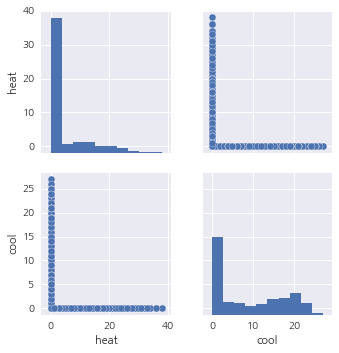

In [207]:
sns.pairplot(df_station_6_only_dropped_h[col_h])
plt.show()

In [197]:
df_station_6_only_dropped_s = df_station_6.copy()
df_station_6_only_dropped_s = remove_m_row(df_station_6, col_s)
print("원래 station_6의 row 개수" + str(len(df_station_6)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_6_only_dropped_s)))

원래 station_6의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1023


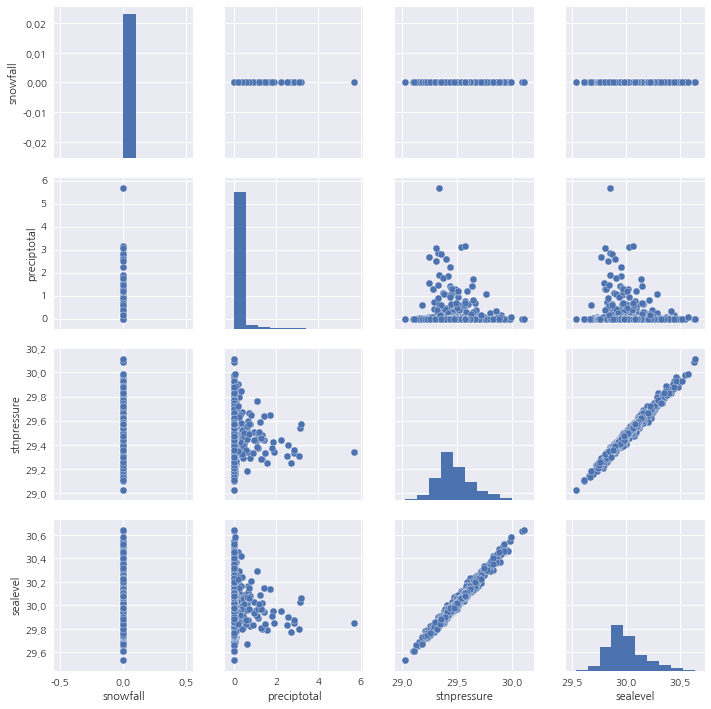

In [198]:
sns.pairplot(df_station_6_only_dropped_s[col_s])
plt.show()

In [203]:
df_station_6_only_dropped_w = df_station_6.copy()
df_station_6_only_dropped_w = remove_m_row(df_station_6, col_w)
print("원래 station_6의 row 개수" + str(len(df_station_6)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_6_only_dropped_w)))

원래 station_6의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1033


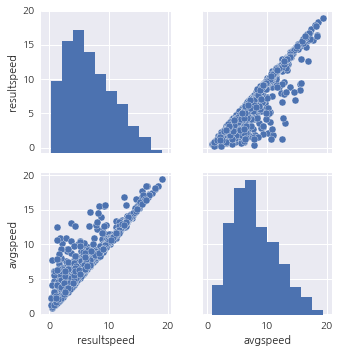

In [204]:
sns.pairplot(df_station_6_only_dropped_w[col_w])
plt.show()